In [32]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_finance
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.accounts as accounts
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from math import floor

In [28]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

In [4]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [5]:
def get_data(count, gran, year, month, day, hour, minute, second):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [6]:
def get_data(count, gran, year, month, day, hour, minute, second):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [7]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [8]:
def get_data_super(start, end, gran):
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                              hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            df = pd.concat([df, df_tmp], ignore_index=True)
            s_year = df_tmp.iat[df_tmp.tail(1).index[0], 0].year
            s_month = df_tmp.iat[df_tmp.tail(1).index[0], 0].month
            s_day = df_tmp.iat[df_tmp.tail(1).index[0], 0].day
            s_hour = df_tmp.iat[df_tmp.tail(1).index[0], 0].hour
            s_minute = df_tmp.iat[df_tmp.tail(1).index[0], 0].minute
            s_second = df_tmp.iat[df_tmp.tail(1).index[0], 0].second
#             print('{}-{}-{}-{}-{}-{}'.format(s_year, s_month, s_day, s_hour, s_minute, s_second))
            # 5000個ずつ取得してエンド超えたら止める
            if s_year > e_year:
                i = False
        # 止めたらはみ出した分をここで切り落とす
        for i in range(len(df.index) - 1000, len(df.index)):
            if df.iat[i, 0].year == e_year and df.iat[i, 0].month == e_month and df.iat[i, 0].day == e_day:
                df = df[0:i+1]
                break
    return df

In [9]:
def set_profit(tmp_i, i, pos, entry_rate, exit_rate, assets, kly_rate, df, pos_df, pos_count):
    fee = 0.008
    pos_count+=1
    if pos == 'entry_long':
        pips = exit_rate - entry_rate - fee
#       print('L利確 entry_rate: {}, exit_rate: {}, pips: {}'.format(entry_rate, exit_rate, pips))

        # ケリー基準で Lot を決める
        kly = assets * kly_rate
        lot = floor(kly / exit_rate)
        if lot < 1000:
            lot = 1000
        elif lot > 3000000:
            lot = 3000000
        profit = lot * 25 * pips
        assets = round(assets + profit, 4)
        tmp_se = pd.Series( [lot, df.iat[tmp_i,0], entry_rate, df.iat[i+1,0], exit_rate, pips, profit, assets ], index=pos_df.columns )
        pos_df = pos_df.append( tmp_se, ignore_index=True )
        return assets, pos_df, pos_count
    else:
        pips = entry_rate - exit_rate - fee
#       print('S利確 entry_rate: {}, exit_rate: {}, pips: {}'.format(entry_rate, exit_rate, pips))

        # ケリー基準で Lot を決める
        kly = assets * kly_rate
        lot = floor(kly / exit_rate)
        if lot < 1000:
            lot = 1000
        elif lot > 3000000:
            lot = 3000000
        profit = lot * 25 * pips
        assets = round(assets + profit, 4)
        tmp_se = pd.Series( [lot, df.iat[tmp_i,0], entry_rate, df.iat[i+1,0], exit_rate, pips, profit, assets ], index=pos_df.columns )
        pos_df = pos_df.append( tmp_se, ignore_index=True )
        return assets, pos_df, pos_count

In [27]:
# バックテスト
def back_test(K, start, end, gran, ref, seed_money, kly_rate):
    K = K # レンジ幅係数
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    entry_rate = 0
    pos_count = 0
    ref = ref
    assets = seed_money
    lot = 0
    kly_rate = kly_rate
    pips_tmp = 0
    los_count = 0
    los_set = -1.5
    tmp_i = 0
    
    df = get_data_super(start, end, gran)
    pos_df = pd.DataFrame(columns=['lot', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12609641-001"
    access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")

    # 実行
    for i in range(len(df.index) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # 次の足の始値
        range_ = abs(round(df.iat[i, 3] - df.iat[i, 4], 3)) # |High - Low| レンジ幅
        range_list.append(range_)
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3) # 直近5個のレンジ幅の平均
            red_range = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open 赤幅(上げ幅)
            blue_range = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low 青幅(下げ幅)
            # print('least_m: {} open_high: {} open_low: {}'.format(least_m, open_high, open_low))

            # 上昇トレンドと判断しロング
            if df.iat[i, 2] < df.iat[i, 5] and least_m < red_range: # 始値より終値の方が高く、5個平均よりもレンジが大きいとき
                if pos == 'entry_long':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        assets, pos_df, pos_count = set_profit(tmp_i, i, pos, entry_rate, exit_rate, assets, kly_rate, df, pos_df, pos_count)
                        if assets < 0:
                            print('game over')
                            break
                    
                    entry_rate = next_rate
                    pos = 'entry_long'
                    tmp_i = i+1
                    # print(pos)
        
            # 下降トレンドと判断しショート
            if df.iat[i, 5] < df.iat[i, 2] and least_m < blue_range: # 終値より始値の方が高く、5個平均よりもレンジが大きいとき
                if pos == 'entry_short':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        assets, pos_df, pos_count = set_profit(tmp_i, i, pos, entry_rate, exit_rate, assets, kly_rate, df, pos_df, pos_count)
                        if assets < 0:
                            print('game over')
                            break
        
                    entry_rate = next_rate
                    pos = 'entry_short'
                    tmp_i = i+1
                    # print(pos)
                    
    print('posision count: {}, seed_money: {}万円, assets: {}万円'.format(pos_count, seed_money/10000, round(assets/10000, 4)))
    return pos_df, df, round(assets/10000, 4)
#     return pos_df, df

In [32]:
# 勝率
win_c = pos_df[pos_df['pips'] >=0].shape[0]
P = win_c / len(pos_df.index)
print('勝率: {}%'.format(round(P*100, 2)))
# ペイオフレシオ
win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
R = win_p / los_p
print('ペイオフレシオ: {}'.format(round(R, 4)))
# ケリー基準
kly = ((R + 1) * P - 1) / R
print('ケリー基準: {}%'.format(round(kly*100, 2)))
# 期待値
win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
E = P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro
print('期待値: {}円'.format(round(E, 2)))
dd = pos_df.sort_values(by='profit', ascending=True).iat[0, 5]
print('最大ドローダウン: {}円'.format(round(dd, 2)))

勝率: 41.37%
ペイオフレシオ: 1.7902
ケリー基準: 8.62%
期待値: 3082.07円
最大ドローダウン: -273210.65円


In [28]:
pos_df = back_test(K=0.5, start='2009-01-01-00-00-00', end='2018-12-31-00-00-00',
                                      gran='H12', ref=5, seed_money=10000000, kly_rate=0.5)

posision count: 1941, seed_money: 1000.0万円, assets: 278805.4202万円


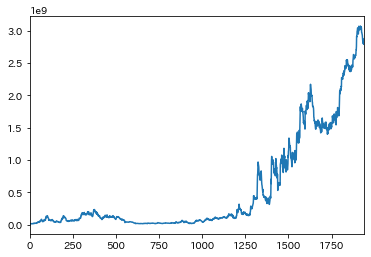

In [29]:
pos_df['assets'].plot()

In [13]:
pos_df, df = back_test(K=0.5, start='2009-01-01-00-00-00', end='2018-12-31-00-00-00',
                                      gran='H12', ref=5, seed_money=1000000, kly_rate=0.086)

posision count: 1809, seed_money: 100.0万円, assets: 569.0925万円


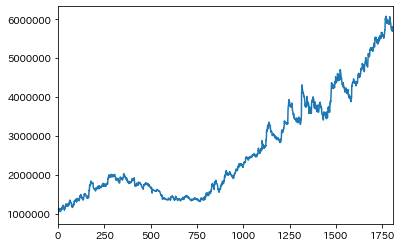

In [82]:
pos_df['assets'].plot()

In [19]:
pos_df.sort_values(by='pips', ascending=True).head()

,lot,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
1354,3039,2016-04-26 21:00:00+00:00,111.318,2016-04-28 09:00:00+00:00,108.124,-3.202,-243271.95,3577725.675
73,1108,2009-06-03 21:00:00+00:00,95.986,2009-06-07 09:00:00+00:00,98.660,-2.682,-74291.40,1197849.150
843,1546,2013-04-03 21:00:00+00:00,93.041,2013-04-04 09:00:00+00:00,95.450,-2.417,-93417.05,1622805.950
507,1794,2011-08-02 21:00:00+00:00,77.151,2011-08-04 09:00:00+00:00,79.430,-2.287,-102571.95,1555086.575
563,1611,2011-10-27 09:00:00+00:00,75.888,2011-10-31 09:00:00+00:00,78.154,-2.274,-91585.35,1372939.775


In [20]:
i = 4242
df[i-5:i+5]

,Time,Volume,Open,High,Low,Close
4237,2016-04-22 09:00:00+00:00,20576,110.334,111.816,110.281,111.779
4238,2016-04-24 21:00:00+00:00,21560,111.854,111.896,111.031,111.168
4239,2016-04-25 09:00:00+00:00,14523,111.168,111.336,110.841,111.198
4240,2016-04-25 21:00:00+00:00,16270,111.220,111.302,110.671,110.847
4241,2016-04-26 09:00:00+00:00,13771,110.846,111.474,110.756,111.308
4242,2016-04-26 21:00:00+00:00,12453,111.318,111.358,111.030,111.198
4243,2016-04-27 09:00:00+00:00,20672,111.200,111.758,111.066,111.455
4244,2016-04-27 21:00:00+00:00,59677,111.456,111.884,107.920,108.122
4245,2016-04-28 09:00:00+00:00,24508,108.124,108.734,107.867,108.101
4246,2016-04-28 21:00:00+00:00,23122,108.120,108.204,106.904,107.092


In [22]:
# i = 4242 でエントリーして i = 4245 で抜けてる
i = 4242
tmp_df = df[i-10:i+5]

### 足と係数両方検証やり直し

In [93]:
# 2010年から2018年の9年間で検証
foot_gran_k = pd.DataFrame(columns=['K', 'gran', 'assets'])
for i in range(1, 25+1):
    K = round(i * 0.1, 2)
    for gran in ['M5', 'M10', 'M15', 'M30',
        'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12',
        'D']:
        pos_df, df, assets = back_test(K=K, start='2009-01-01-00-00-00', end='2018-12-31-00-00-00',
                                      gran=gran, ref=5, seed_money=10000000, kly_rate=0.05)
        tmp_se = pd.Series( [K, gran, assets ], index=foot_gran_k.columns )
        foot_gran_k = foot_gran_k.append( tmp_se, ignore_index=True )

KeyboardInterrupt: 

In [92]:
foot_gran_k.sort_values(by='assets', ascending=False).head(20)

,K,gran,assets
58,0.5,H12,2885.9834
81,0.7,H8,2608.0473
46,0.4,H12,2394.8220
69,0.6,H8,2278.4292
93,0.8,H8,2195.1632
151,1.3,H4,2017.9559
103,0.9,H4,2016.8186
162,1.4,H3,2001.2993
115,1.0,H4,1993.1868
70,0.6,H12,1937.2280


In [29]:
# 2013年から2018年の9年間で検証
foot_gran_k = pd.DataFrame(columns=['K', 'gran', 'assets'])
for i in range(1, 25+1):
    K = round(i * 0.1, 2)
    for gran in ['M5', 'M10', 'M15', 'M30',
        'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12',
        'D']:
        pos_df, df, assets = back_test(K=K, start='2013-01-01-00-00-00', end='2018-12-31-00-00-00',
                                      gran=gran, ref=5, seed_money=10000000, kly_rate=0.05)
        tmp_se = pd.Series( [K, gran, assets ], index=foot_gran_k.columns )
        foot_gran_k = foot_gran_k.append( tmp_se, ignore_index=True )

game over
posision count: 23509, seed_money: 1000.0万円, assets: -0.0087万円
game over
posision count: 21638, seed_money: 1000.0万円, assets: -0.137万円
game over
posision count: 22428, seed_money: 1000.0万円, assets: -0.0243万円
game over
posision count: 25124, seed_money: 1000.0万円, assets: -0.1372万円
posision count: 20504, seed_money: 1000.0万円, assets: 132.9317万円
posision count: 10241, seed_money: 1000.0万円, assets: 233.621万円
posision count: 7239, seed_money: 1000.0万円, assets: 388.6416万円
posision count: 4695, seed_money: 1000.0万円, assets: 564.8562万円
posision count: 3077, seed_money: 1000.0万円, assets: 888.3935万円
posision count: 2308, seed_money: 1000.0万円, assets: 1255.4695万円
posision count: 1518, seed_money: 1000.0万円, assets: 1836.8676万円
posision count: 804, seed_money: 1000.0万円, assets: 937.1341万円
game over
posision count: 23007, seed_money: 1000.0万円, assets: -0.0226万円
game over
posision count: 20901, seed_money: 1000.0万円, assets: -0.0559万円
game over
posision count: 23077, seed_money: 1000.0万円, as

posision count: 2098, seed_money: 1000.0万円, assets: 1415.6321万円
posision count: 1436, seed_money: 1000.0万円, assets: 1402.74万円
posision count: 883, seed_money: 1000.0万円, assets: 1590.7216万円
posision count: 594, seed_money: 1000.0万円, assets: 1018.5481万円
posision count: 465, seed_money: 1000.0万円, assets: 1252.8271万円
posision count: 281, seed_money: 1000.0万円, assets: 1575.1681万円
posision count: 147, seed_money: 1000.0万円, assets: 894.4852万円
game over
posision count: 28283, seed_money: 1000.0万円, assets: -0.0838万円
posision count: 18100, seed_money: 1000.0万円, assets: 109.2966万円
posision count: 11799, seed_money: 1000.0万円, assets: 381.8122万円
posision count: 6194, seed_money: 1000.0万円, assets: 1075.7426万円
posision count: 3432, seed_money: 1000.0万円, assets: 1639.5182万円
posision count: 1724, seed_money: 1000.0万円, assets: 1500.47万円
posision count: 1214, seed_money: 1000.0万円, assets: 1145.1129万円
posision count: 721, seed_money: 1000.0万円, assets: 1793.1674万円
posision count: 494, seed_money: 1000.0万円,

posision count: 1357, seed_money: 1000.0万円, assets: 1574.7523万円
posision count: 782, seed_money: 1000.0万円, assets: 1236.3102万円
posision count: 380, seed_money: 1000.0万円, assets: 1261.3031万円
posision count: 264, seed_money: 1000.0万円, assets: 1304.6117万円
posision count: 135, seed_money: 1000.0万円, assets: 1640.1359万円
posision count: 91, seed_money: 1000.0万円, assets: 1078.7217万円
posision count: 58, seed_money: 1000.0万円, assets: 1049.5593万円
posision count: 42, seed_money: 1000.0万円, assets: 1026.7389万円
posision count: 19, seed_money: 1000.0万円, assets: 1254.5047万円
posision count: 6581, seed_money: 1000.0万円, assets: 623.0345万円
posision count: 3003, seed_money: 1000.0万円, assets: 1033.0465万円
posision count: 2059, seed_money: 1000.0万円, assets: 1494.0796万円
posision count: 1194, seed_money: 1000.0万円, assets: 1615.4024万円
posision count: 690, seed_money: 1000.0万円, assets: 1543.8887万円
posision count: 332, seed_money: 1000.0万円, assets: 1406.5258万円
posision count: 230, seed_money: 1000.0万円, assets: 1237

In [30]:
foot_gran_k.sort_values(by='assets', ascending=False).head(20)

,K,gran,assets
58,0.5,H12,2306.1671
290,2.5,M15,2188.6113
162,1.4,H3,2131.4755
81,0.7,H8,2013.9189
46,0.4,H12,1994.2702
223,1.9,H4,1910.6142
151,1.3,H4,1903.5594
34,0.3,H12,1899.2839
163,1.4,H4,1891.2723
247,2.1,H4,1865.8111


In [31]:
foot_gran_k.to_csv('foot_gran_k_5y.csv')

### ローソクチャート

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


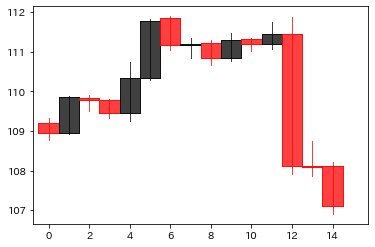

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
mpl_finance.candlestick2_ohlc(ax, opens=tmp_df['Open'], highs=tmp_df['High'], lows=tmp_df['Low'], closes=tmp_df['Close'], width=1)
fig.show()

### 口座情報の取得

In [33]:
r = accounts.AccountSummary(accountID)
api.request(r)

{'account': {'guaranteedStopLossOrderMode': 'DISABLED',
  'hedgingEnabled': False,
  'id': '101-009-12609641-001',
  'createdTime': '2019-11-03T01:10:52.657827638Z',
  'currency': 'JPY',
  'createdByUserID': 12609641,
  'alias': 'Primary',
  'marginRate': '0.04',
  'lastTransactionID': '3',
  'balance': '3000000.0000',
  'openTradeCount': 0,
  'openPositionCount': 0,
  'pendingOrderCount': 0,
  'pl': '0.0000',
  'resettablePL': '0.0000',
  'resettablePLTime': '0',
  'financing': '0.0000',
  'commission': '0.0000',
  'dividend': '0',
  'guaranteedExecutionFees': '0.0000',
  'unrealizedPL': '0.0000',
  'NAV': '3000000.0000',
  'marginUsed': '0.0000',
  'marginAvailable': '3000000.0000',
  'positionValue': '0.0000',
  'marginCloseoutUnrealizedPL': '0.0000',
  'marginCloseoutNAV': '3000000.0000',
  'marginCloseoutMarginUsed': '0.0000',
  'marginCloseoutPositionValue': '0.0000',
  'marginCloseoutPercent': '0.00000',
  'withdrawalLimit': '3000000.0000'},
 'lastTransactionID': '3'}